# **Deep Learning Project: Garbage Classification - Preprocessing**

I chose to split the work into five notebooks. The first notebook focuses on initial pre-processing steps, including two variations of image sizes. Two additional notebooks are dedicated to applying deep learning models to each image size. Another notebook exclusively employs pre-trained models. Finally, the last notebook is dedicated to fine-tuning and optimizing parameters for each model. In the current notebook, I present the primary pre-processing steps as well as some data exploration.

## 1. Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import re
import cv2
import shutil
import squarify
from glob import glob
from pathlib import Path
import pickle
from PIL import Image
from collections import defaultdict, Counter
from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping


## 2. Import the Dataset

### **Data Source** 

 
Kaggle dataset: https://www.kaggle.com/datasets/mostafaabla/garbage-classification

In [1]:
data_dir = './garbage_classification'

## 3. Initial Analysis

An initial analysis was conducted to better understand the characteristics of the images, which helped in determining how to manage them effectively.

In [3]:
# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(data_dir)

In [4]:
# Dictionary to store garbage type and number of images
num_images_per_category = {}

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()
check_channels = {}

# Lists to store width and height
widths = []
heights = []

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(data_dir, garbage_type)
    channel_path = []
    channel_size = []

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg'))]

        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")

        # Store the number of images per category
        num_images_per_category[garbage_type] = num_images

        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))
                if channels not in channel_size:
                    channel_size.append(channels)
                    channel_path.append((image_path, channels))

                # Append width and height to the lists
                widths.append(width)
                heights.append(height)

        check_channels[garbage_type] = channel_path

# Determine if all images in the entire dataset have the same dimensions
if len(all_dimensions_set) == 1:
    width, height, channels = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

battery folder contains 945 images.
biological folder contains 985 images.
brown-glass folder contains 607 images.
cardboard folder contains 891 images.
clothes folder contains 5325 images.
green-glass folder contains 629 images.
metal folder contains 769 images.
paper folder contains 1050 images.
plastic folder contains 865 images.
shoes folder contains 1977 images.
trash folder contains 697 images.
white-glass folder contains 775 images.

The images in the dataset have different dimensions or color channels.


### 3.1 Images Exploration (sizes across classes)

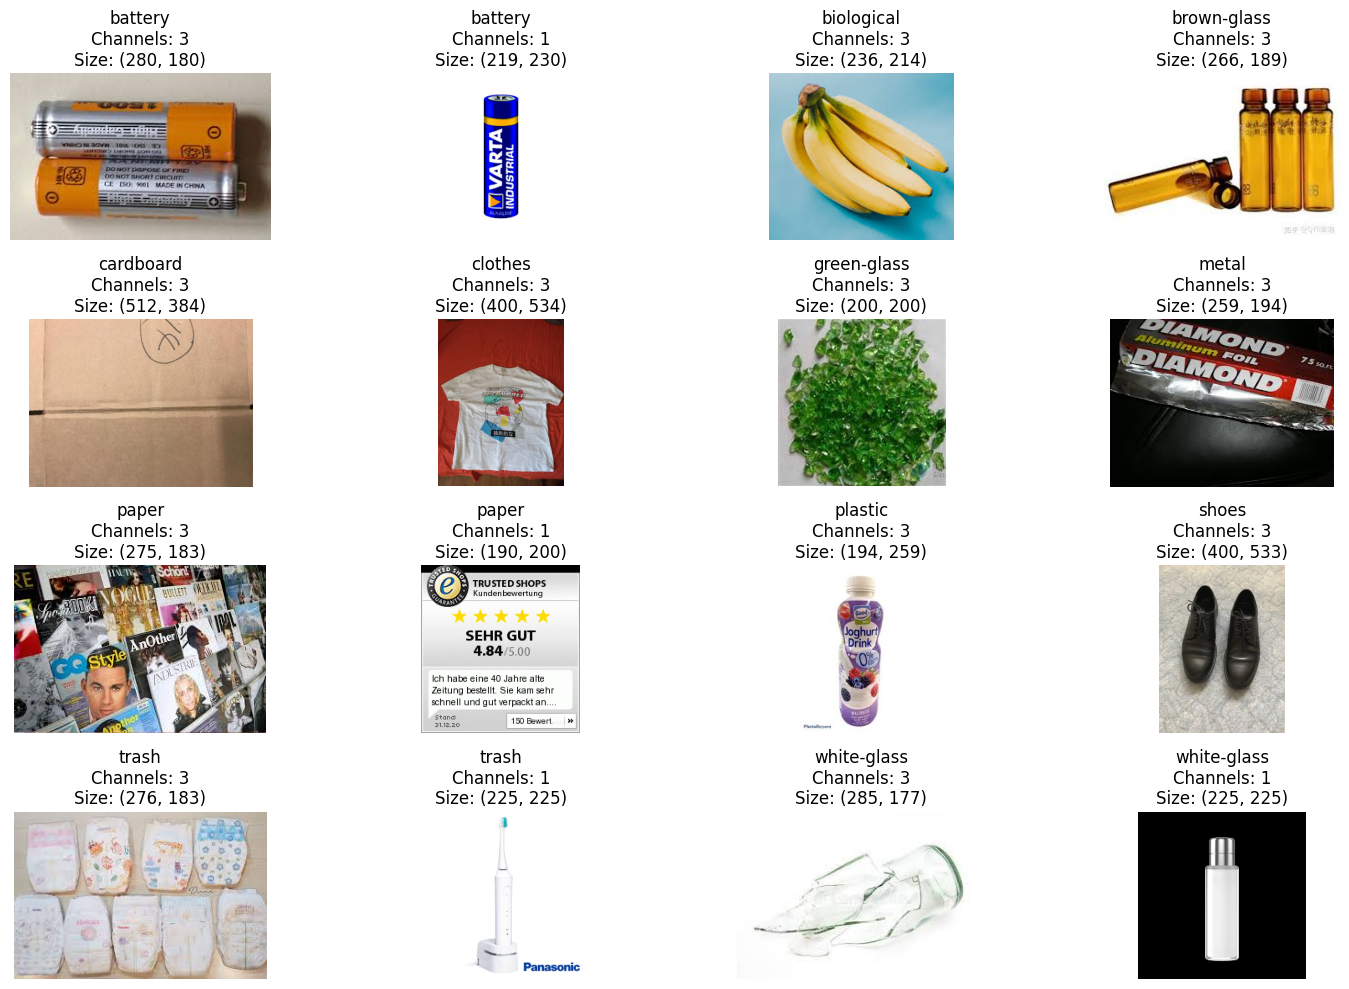

In [5]:
# Define the figure size and number of columns for subplots
fig_size = (15, 10)

# Create a figure and axes for subplots
fig, axes = plt.subplots(4, 3, figsize=fig_size)

# Flatten the axes array if it's multidimensional
axes = axes.flatten()

# Initialize index for subplot
i = 0

# Iterate over each key-value pair in the dictionary
for garbage_type, paths in check_channels.items():
    # Iterate over each image path for the current garbage type
    for path, channels in paths:
        # Open the image
        img = Image.open(path)
        size = img.size
        # Plot the image
        axes[i].imshow(img)
        axes[i].axis('off')
        # Increment the index for the next subplot
        i += 1

# Hide any empty subplots
for j in range(i, len(axes)):
    axes[j].axis('off')

# Adjust the layout to prevent overlapping titles
plt.tight_layout()
plt.show()

### 3.2 Images Distributions Across the 12 Classes 

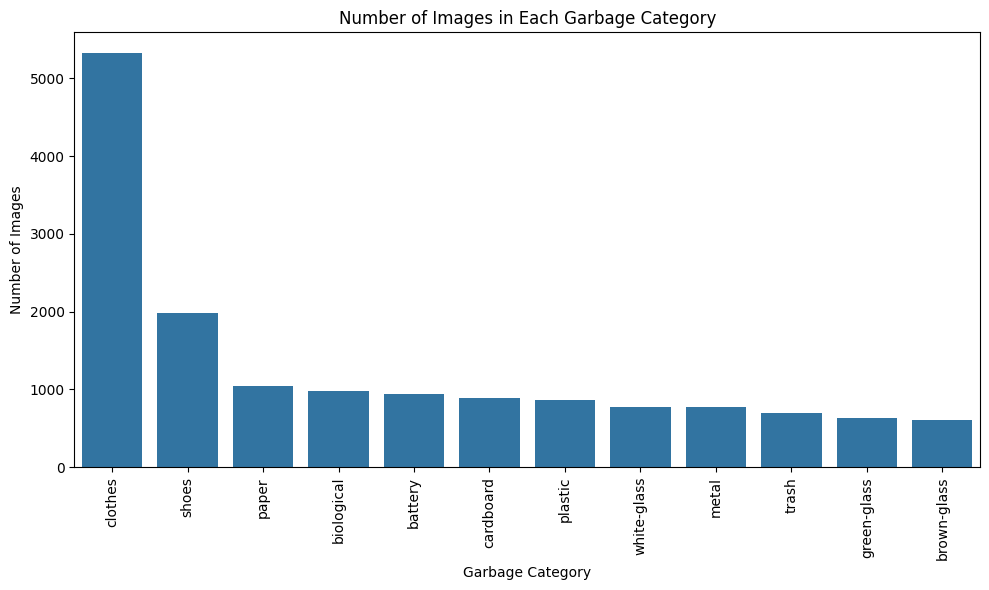

In [6]:
# Create a sorted list of garbage types and corresponding number of images
sorted_num_images_per_category = sorted(num_images_per_category.items(), key=lambda x: x[1], reverse=True)
sorted_garbage_types = [garbage_type for garbage_type, num_images in sorted_num_images_per_category]
sorted_num_images = [num_images for garbage_type, num_images in sorted_num_images_per_category]

# Plotting the number of images per category
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_garbage_types, y=sorted_num_images)
plt.title('Number of Images in Each Garbage Category')
plt.xlabel('Garbage Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 3.3 Images Sizes Distribution

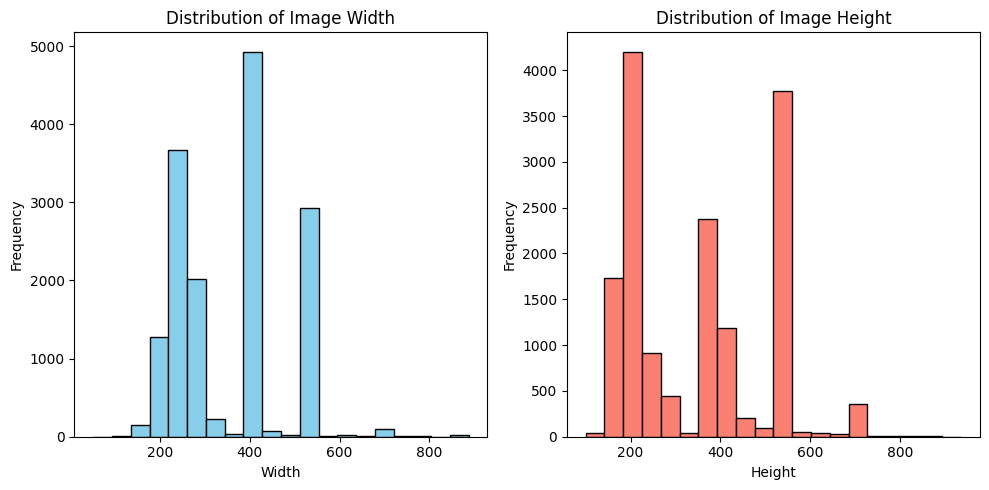

In [7]:
# Plotting the distributions
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
# Images sizes' statistics
smallest_width = min(widths)
smallest_height = min(heights)
largest_width = max(widths)
largest_height = max(heights)
average_width = np.mean(widths)
average_height = np.mean(heights)
std_dev_width = np.std(widths)
std_dev_height = np.std(heights)

# Display statistics in a table
print("Statistics of Images' Sizes:")
print("-----------------------------------------")
print("| Statistic     | Width     | Height    |")
print("|---------------|-----------|-----------|")
print("| Smallest      | {:<9} | {:<9} |".format(smallest_width, smallest_height))
print("| Largest       | {:<9} | {:<9} |".format(largest_width, largest_height))
print("| Average       | {:<9.2f} | {:<9.2f} |".format(average_width, average_height))
print("| Std. Dev.     | {:<9.2f} | {:<9.2f} |".format(std_dev_width, std_dev_height))
print("-----------------------------------------")

Statistics of Images' Sizes:
-----------------------------------------
| Statistic     | Width     | Height    |
|---------------|-----------|-----------|
| Smallest      | 51        | 100       |
| Largest       | 888       | 936       |
| Average       | 349.82    | 351.71    |
| Std. Dev.     | 117.54    | 149.41    |
-----------------------------------------


## 4. Data Preprocessing


   Resizing the images to a fixed size ensures that all images have the same
 dimensions, which is necessary for feeding them into a neural network. I tried the approach of resizing the images to similar values to the average of the images' sizes. However, this turned out to be extremely computational complex. Therefore, I proceeded with resizing to a value similar to the minimum of the images' sizes (50x50) and after experimenting several models we ended up trying models with the images by 128x128.


## 4.1 Resize

#### 4.1.1 Resize to 50x50px

In [10]:
# Define the source and destination directories
source_dir = './garbage_classification'
resized_dir_50 = './resized and split 50/resized_data_50'

Path(resized_dir_50).mkdir(parents=True, exist_ok=True)

# Image dimensions to resize to
h, w = 50, 50

In [14]:
# Function to resize and save an image
def resize_and_save_image(image_path, output_path):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (w, h))
    cv2.imwrite(output_path, img_resized)

# Loop through all images in all class directories
for class_folder in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_folder)
    if os.path.isdir(class_path):
        for image_path in glob(os.path.join(class_path, '*.jpg')):
            # Construct the output path while keeping the original image name
            image_name = os.path.basename(image_path)
            output_path = os.path.join(resized_dir_50, image_name)

            # Resize and save the image
            resize_and_save_image(image_path, output_path)
            print(f"Processed and saved: {output_path}")

print("All images have been processed and saved.")

Processed and saved: ./resized_data_50\battery1.jpg
Processed and saved: ./resized_data_50\battery10.jpg
Processed and saved: ./resized_data_50\battery100.jpg
Processed and saved: ./resized_data_50\battery101.jpg
Processed and saved: ./resized_data_50\battery102.jpg
Processed and saved: ./resized_data_50\battery103.jpg
Processed and saved: ./resized_data_50\battery104.jpg
Processed and saved: ./resized_data_50\battery105.jpg
Processed and saved: ./resized_data_50\battery106.jpg
Processed and saved: ./resized_data_50\battery107.jpg
Processed and saved: ./resized_data_50\battery108.jpg
Processed and saved: ./resized_data_50\battery109.jpg
Processed and saved: ./resized_data_50\battery11.jpg
Processed and saved: ./resized_data_50\battery110.jpg
Processed and saved: ./resized_data_50\battery111.jpg
Processed and saved: ./resized_data_50\battery112.jpg
Processed and saved: ./resized_data_50\battery113.jpg
Processed and saved: ./resized_data_50\battery114.jpg
Processed and saved: ./resized_d

In [15]:
# Regular expression to match "class" part of the filename "*class**number*.jpg"
class_name_pattern = re.compile(r'(\D+)\d+\.jpg$')
# Create lists to store file paths and corresponding class labels
file_paths = []
class_labels = []
# Assuming all your images are in the same folder
for filename in os.listdir(resized_dir_50):
    file_path = os.path.join(resized_dir_50, filename)
    if os.path.isfile(file_path) and filename.endswith('.jpg'):
        match = class_name_pattern.match(filename)
        if match:
            class_name = match.group(1)
            file_paths.append(file_path)
            class_labels.append(class_name)

# Ensure class labels are numeric
unique_classes = np.unique(class_labels)
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(unique_classes)}
numeric_labels = [class_to_idx[cls_name] for cls_name in class_labels]

# Shuffle the data
combined_data = list(zip(file_paths, numeric_labels))
random.shuffle(combined_data)
file_paths, numeric_labels = zip(*combined_data)

# Split the data into training, validation, and testing sets
train_paths, test_val_paths, train_labels, test_val_labels = train_test_split(file_paths, numeric_labels, test_size=0.2, stratify=numeric_labels)
test_paths, val_paths, test_labels, val_labels = train_test_split(test_val_paths, test_val_labels, test_size=0.6, stratify=test_val_labels)

# Define output directory
resized_dir_50_split = './resized and split 50/train_test_val_50'

# Create output directory if it doesn't exist
try:
    os.makedirs(resized_dir_50_split)
except FileExistsError:
    print(f"Directory '{resized_dir_50_split}' already exists.")

# Define subdirectories
train_dir = os.path.join(resized_dir_50_split, 'train')
test_dir = os.path.join(resized_dir_50_split, 'test')
val_dir = os.path.join(resized_dir_50_split, 'validation')

# Create subdirectories
for directory in [train_dir, test_dir, val_dir]:
    try:
        os.makedirs(directory)
    except FileExistsError:
        print(f"Directory '{directory}' already exists.")

# Function to copy images to corresponding directories
def copy_images_to_dir(paths, labels, destination_dir):
    for path, label in zip(paths, labels):
        class_name = unique_classes[label]
        class_dir = os.path.join(destination_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(path, class_dir)

# Copy images to corresponding directories
copy_images_to_dir(train_paths, train_labels, train_dir)
copy_images_to_dir(test_paths, test_labels, test_dir)
copy_images_to_dir(val_paths, val_labels, val_dir)

def count_images(directory):
    count = sum(len(files) for _, _, files in os.walk(directory))
    return count

# Count the number of images in each set
train_count = count_images(train_dir)
test_count = count_images(test_dir)
val_count = count_images(val_dir)

# Print the counts
print("Number of images in training set:", train_count)
print("Number of images in testing set:", test_count)
print("Number of images in validation set:", val_count)

Number of images in training set: 12412
Number of images in testing set: 1241
Number of images in validation set: 1862


#### 4.1.2 Resize to 128x128px

In [14]:
# Define the source and destination directories
source_dir = './garbage_classification'
resized_dir_128 = './resized and split 128/resized_data_128/resized_data_128'

Path(resized_dir_128).mkdir(parents=True, exist_ok=True)

# Image dimensions to resize to
h, w = 128, 128

In [17]:
# Loop through all images in all class directories
for class_folder in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_folder)
    if os.path.isdir(class_path):
        for image_path in glob(os.path.join(class_path, '*.jpg')):
            # Construct the output path while keeping the original image name
            image_name = os.path.basename(image_path)
            output_path = os.path.join(resized_dir_128, image_name)

            # Resize and save the image
            resize_and_save_image(image_path, output_path)
            print(f"Processed and saved: {output_path}")

print("All images have been processed and saved.")

Processed and saved: ./resized_data128\battery1.jpg
Processed and saved: ./resized_data128\battery10.jpg
Processed and saved: ./resized_data128\battery100.jpg
Processed and saved: ./resized_data128\battery101.jpg
Processed and saved: ./resized_data128\battery102.jpg
Processed and saved: ./resized_data128\battery103.jpg
Processed and saved: ./resized_data128\battery104.jpg
Processed and saved: ./resized_data128\battery105.jpg
Processed and saved: ./resized_data128\battery106.jpg
Processed and saved: ./resized_data128\battery107.jpg
Processed and saved: ./resized_data128\battery108.jpg
Processed and saved: ./resized_data128\battery109.jpg
Processed and saved: ./resized_data128\battery11.jpg
Processed and saved: ./resized_data128\battery110.jpg
Processed and saved: ./resized_data128\battery111.jpg
Processed and saved: ./resized_data128\battery112.jpg
Processed and saved: ./resized_data128\battery113.jpg
Processed and saved: ./resized_data128\battery114.jpg
Processed and saved: ./resized_d

In [16]:
# Regular expression to match "class" part of the filename "*class**number*.jpg"
class_name_pattern = re.compile(r'(\D+)\d+\.jpg$')
# Create lists to store file paths and corresponding class labels
file_paths = []
class_labels = []
# Assuming all your images are in the same folder
for filename in os.listdir(resized_dir_128):
    file_path = os.path.join(resized_dir_128, filename)
    if os.path.isfile(file_path) and filename.endswith('.jpg'):
        match = class_name_pattern.match(filename)
        if match:
            class_name = match.group(1)
            file_paths.append(file_path)
            class_labels.append(class_name)

# Ensure class labels are numeric
unique_classes = np.unique(class_labels)
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(unique_classes)}
numeric_labels = [class_to_idx[cls_name] for cls_name in class_labels]

# Shuffle the data
combined_data = list(zip(file_paths, numeric_labels))
random.shuffle(combined_data)
file_paths, numeric_labels = zip(*combined_data)

# Split the data into training, validation, and testing sets
train_paths, test_val_paths, train_labels, test_val_labels = train_test_split(file_paths, numeric_labels, test_size=0.2, stratify=numeric_labels)
test_paths, val_paths, test_labels, val_labels = train_test_split(test_val_paths, test_val_labels, test_size=0.6, stratify=test_val_labels)

# Define output directory
resized_dir_128_split = './resized and split 128/train_test_val_128/train_test_val_128'

# Create output directory if it doesn't exist
try:
    os.makedirs(resized_dir_128_split)
except FileExistsError:
    print(f"Directory '{resized_dir_128_split}' already exists.")

# Define subdirectories
train_dir = os.path.join(resized_dir_128_split, 'train')
test_dir = os.path.join(resized_dir_128_split, 'test')
val_dir = os.path.join(resized_dir_128_split, 'validation')

# Create subdirectories
for directory in [train_dir, test_dir, val_dir]:
    try:
        os.makedirs(directory)
    except FileExistsError:
        print(f"Directory '{directory}' already exists.")

# Function to copy images to corresponding directories
def copy_images_to_dir(paths, labels, destination_dir):
    for path, label in zip(paths, labels):
        class_name = unique_classes[label]
        class_dir = os.path.join(destination_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(path, class_dir)

# Copy images to corresponding directories
copy_images_to_dir(train_paths, train_labels, train_dir)
copy_images_to_dir(test_paths, test_labels, test_dir)
copy_images_to_dir(val_paths, val_labels, val_dir)

def count_images(directory):
    count = sum(len(files) for _, _, files in os.walk(directory))
    return count

# Count the number of images in each set
train_count = count_images(train_dir)
test_count = count_images(test_dir)
val_count = count_images(val_dir)

# Print the counts
print("Number of images in training set:", train_count)
print("Number of images in testing set:", test_count)
print("Number of images in validation set:", val_count)

Directory './resized and split 128/train_test_val_128/train_test_val_128' already exists.
Number of images in training set: 12412
Number of images in testing set: 1241
Number of images in validation set: 1862


## 4.2 Train Test Split analysis

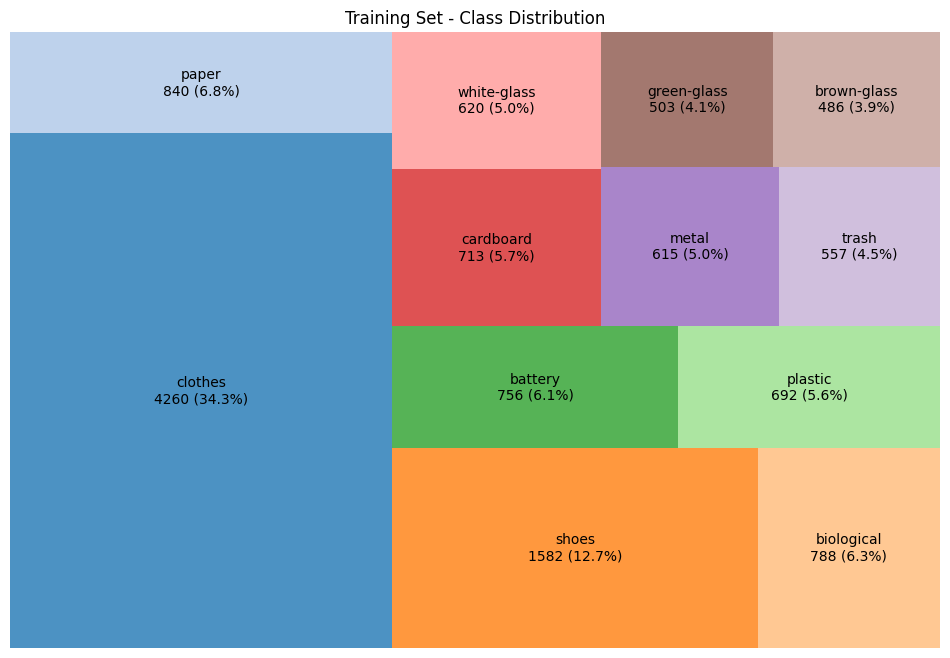

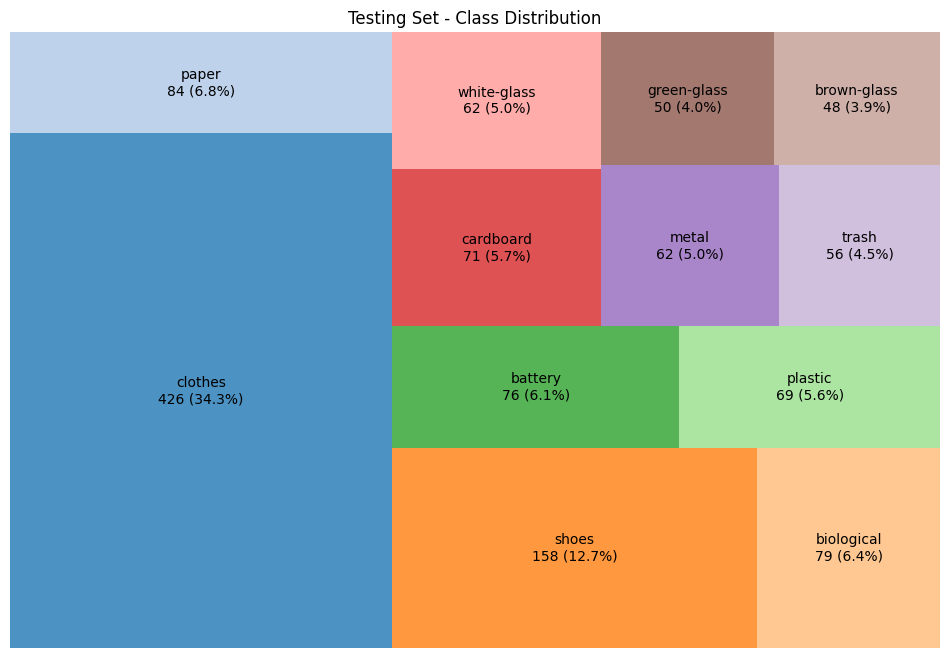

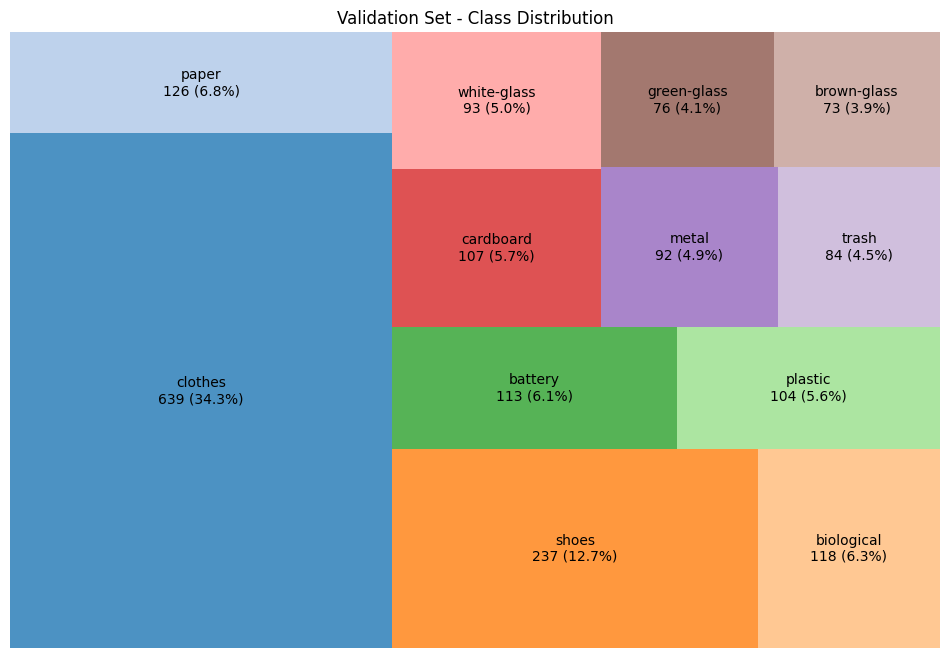

In [20]:
garbage_classes = ['clothes', 'paper', 'shoes', 'biological', 'battery', 'plastic',
                   'cardboard', 'white-glass', 'metal', 'trash', 'green-glass', 'brown-glass']

# Function to count images in each class directory and return a dictionary
def get_class_distribution(directory):
    class_distribution = {}
    for class_name in garbage_classes:
        class_dir = os.path.join(directory, class_name)
        try:
            # Count only files, exclude subdirectories if any
            num_images = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])
            class_distribution[class_name] = num_images
        except FileNotFoundError:
            class_distribution[class_name] = 0  # If the directory does not exist, assign 0 images
    return class_distribution

# Function to plot a treemap for the given class distribution
def plot_treemap(class_distribution, title):
    total_images = sum(class_distribution.values())
    labels = [f'{label}\n{count} ({count/total_images:.1%})' if count > 0 else '' for label, count in class_distribution.items()]
    sizes = [count for count in class_distribution.values() if count > 0]
    colors = plt.cm.tab20(range(len(labels)))

    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Paths to directories
train_dir = os.path.join(resized_dir_128_split, 'train')
test_dir = os.path.join(resized_dir_128_split, 'test')
val_dir = os.path.join(resized_dir_128_split, 'validation')

# Get distributions
train_distribution = get_class_distribution(train_dir)
test_distribution = get_class_distribution(test_dir)
val_distribution = get_class_distribution(val_dir)

# Plot treemaps
plot_treemap(train_distribution, 'Training Set - Class Distribution')
plot_treemap(test_distribution, 'Testing Set - Class Distribution')
plot_treemap(val_distribution, 'Validation Set - Class Distribution')


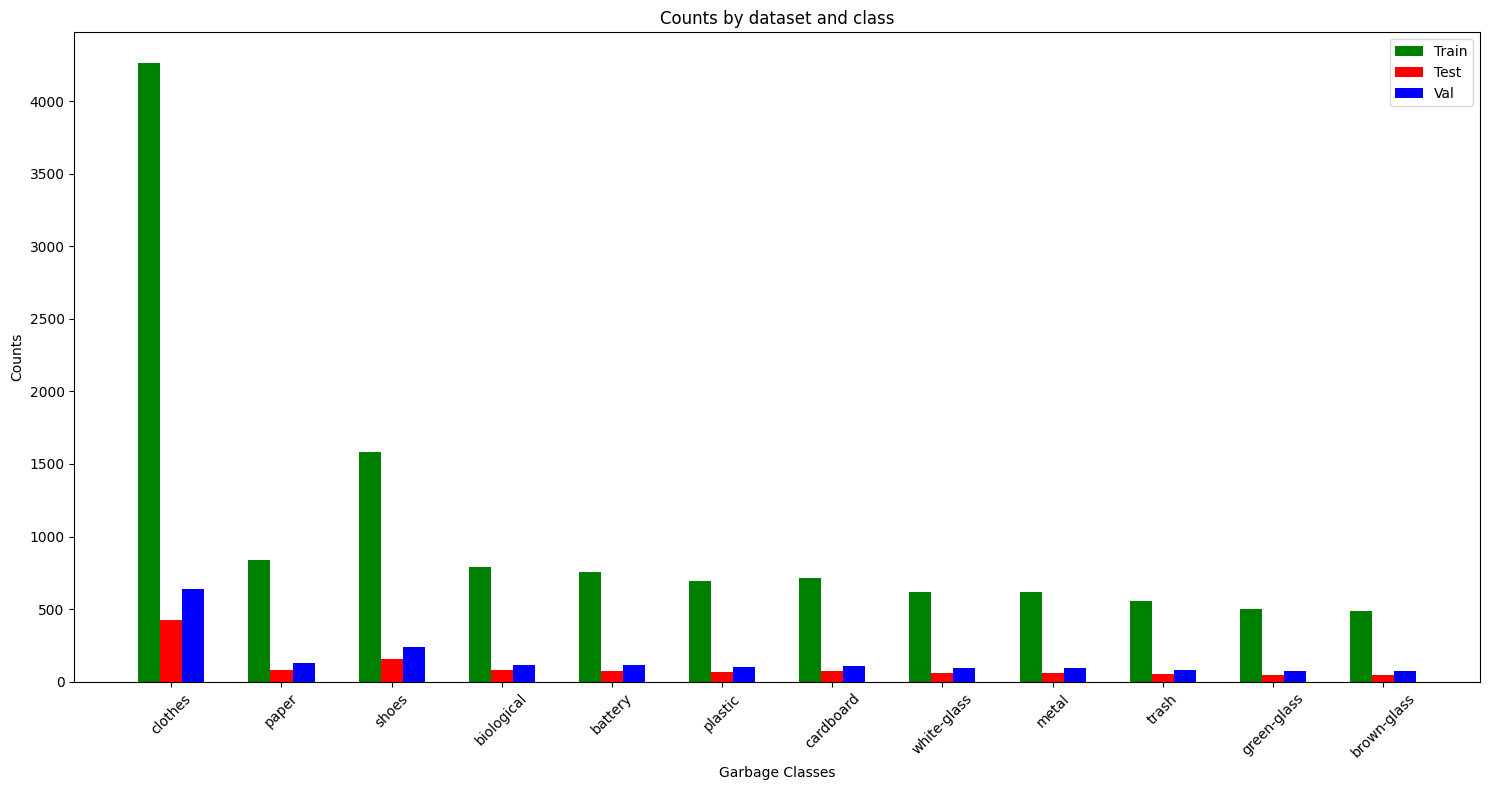

In [23]:
# Function to count images for each class in a directory
def count_images_by_class(directory, garbage_classes):
    counts = {cls_name: 0 for cls_name in garbage_classes}
    for cls_name in garbage_classes:
        class_dir = os.path.join(directory, cls_name)
        if os.path.isdir(class_dir):
            counts[cls_name] = len([entry for entry in os.listdir(class_dir) if entry.endswith('.jpg')])
    return counts

# Get counts for each class in each dataset
train_counts = count_images_by_class(train_dir, garbage_classes)
test_counts = count_images_by_class(test_dir, garbage_classes)
val_counts = count_images_by_class(val_dir, garbage_classes)

# Data for plotting
n_groups = len(garbage_classes)
index = np.arange(n_groups)
bar_width = 0.2

# Prepare the counts for each class for plotting
train_data = [train_counts[cls_name] for cls_name in garbage_classes]
test_data = [test_counts[cls_name] for cls_name in garbage_classes]
val_data = [val_counts[cls_name] for cls_name in garbage_classes]

# Create the bar chart
fig, ax = plt.subplots(figsize=(15, 8))

train_bars = ax.bar(index, train_data, bar_width, color='g', label='Train')
test_bars = ax.bar(index + bar_width, test_data, bar_width, color='r', label='Test')
val_bars = ax.bar(index + 2*bar_width, val_data, bar_width, color='b', label='Val')

# Add labels, title, and axes ticks
ax.set_xlabel('Garbage Classes')
ax.set_ylabel('Counts')
ax.set_title('Counts by dataset and class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(garbage_classes, rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()